In [44]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import warnings; warnings.filterwarnings("ignore")
%matplotlib inline

In [45]:
model = load_vgg_model("vggmodel/imagenet-vgg-verydeep-19.mat")
print(model)

{'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv5_1': <tf.Tensor 'Relu_12:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 1

(300, 400, 3)


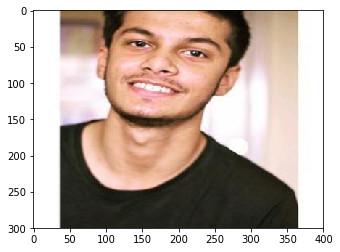

In [46]:
content_image = scipy.misc.imread("./images/kartik.jpg")
print(content_image.shape)
imshow(content_image)

In [47]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
   
    a_C_unrolled = tf.transpose(tf.reshape(a_C,[-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[-1]))
    
    
    norm = n_H*n_W*n_C
    J_content = 0.25*(1/norm)*tf.reduce_sum((a_C_unrolled-a_G_unrolled)**2)
    
    
    return J_content

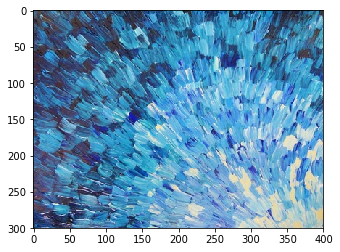

In [48]:
style_image = scipy.misc.imread("images/stylesample6.jpg")
imshow(style_image)

In [49]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A,A,transpose_b=True)
    
    return GA

In [50]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))

    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

   
    J_style_layer = tf.reduce_sum((GS-GG)**2)/(4*n_C**2*(n_H*n_W)**2)
    
    return J_style_layer

In [51]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        
        out = model[layer_name]

        
        a_S = sess.run(out)

        a_G = out
        
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        
        J_style += coeff * J_style_layer

    return J_style

In [52]:
def total_cost(J_content, J_style, alpha =None ,beta = None):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content + beta*J_style
    
    
    return J

In [53]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [54]:
content_image = scipy.misc.imread("images/kartik.jpg")
content_image = reshape_and_normalize_image(content_image)

In [55]:
style_image = scipy.misc.imread("images/stylesample6.jpg")
style_image = reshape_and_normalize_image(style_image)

In [56]:
generate_image = generate_noise_image(content_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


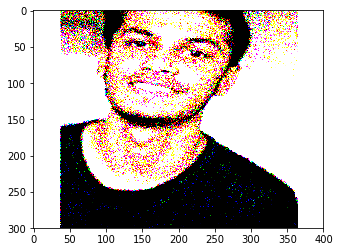

In [57]:
imshow(generate_image[0])

In [58]:
model = load_vgg_model("vggmodel/imagenet-vgg-verydeep-19.mat")

In [59]:
sess.run(model['input'].assign(content_image))


out = model['conv4_2']

a_C = sess.run(out)

a_G = out

J_content = compute_content_cost(a_C, a_G)

In [60]:
STYLE_LAYERS = [
    ('conv1_1', 0.01),
    ('conv2_1', 0.1),
    ('conv3_1', 0.19),
    ('conv4_1', 0.3),
    ('conv5_1', 0.4)]
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [61]:
J = total_cost(J_content, J_style, alpha=2000, beta=2)

In [62]:
optimizer = tf.train.AdamOptimizer(4.5)

train_step = optimizer.minimize(J)

In [63]:
def model_nn(sess, input_image, num_iterations = 1200):
    
    sess.run(tf.global_variables_initializer())
    
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        sess.run(train_step)
        print("iter={}".format(i))
        
        generated_image = sess.run(model['input'])
        if i%100==0:    
            save_image("output/image_" + str(i) + ".png", generated_image)
    
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [64]:

generated_image = model_nn(sess, generate_image)
generated_image

iter=0
iter=1
iter=2
iter=3
iter=4
iter=5
iter=6
iter=7
iter=8
iter=9
iter=10
iter=11
iter=12
iter=13
iter=14
iter=15
iter=16
iter=17
iter=18
iter=19
iter=20
iter=21
iter=22
iter=23
iter=24
iter=25
iter=26
iter=27
iter=28
iter=29
iter=30
iter=31
iter=32
iter=33
iter=34
iter=35
iter=36
iter=37
iter=38
iter=39
iter=40
iter=41
iter=42
iter=43
iter=44
iter=45
iter=46
iter=47
iter=48
iter=49
iter=50
iter=51
iter=52
iter=53
iter=54
iter=55
iter=56
iter=57
iter=58
iter=59
iter=60
iter=61
iter=62
iter=63
iter=64
iter=65
iter=66
iter=67
iter=68
iter=69
iter=70
iter=71
iter=72
iter=73
iter=74
iter=75
iter=76
iter=77
iter=78
iter=79
iter=80
iter=81
iter=82
iter=83
iter=84
iter=85
iter=86
iter=87
iter=88
iter=89
iter=90
iter=91
iter=92
iter=93
iter=94
iter=95
iter=96
iter=97
iter=98
iter=99
iter=100
iter=101
iter=102
iter=103
iter=104
iter=105
iter=106
iter=107
iter=108
iter=109
iter=110
iter=111
iter=112
iter=113
iter=114
iter=115
iter=116
iter=117
iter=118
iter=119
iter=120
iter=121
iter=122
ite

iter=923
iter=924
iter=925
iter=926
iter=927
iter=928
iter=929
iter=930
iter=931
iter=932
iter=933
iter=934
iter=935
iter=936
iter=937
iter=938
iter=939
iter=940
iter=941
iter=942
iter=943
iter=944
iter=945
iter=946
iter=947
iter=948
iter=949
iter=950
iter=951
iter=952
iter=953
iter=954
iter=955
iter=956
iter=957
iter=958
iter=959
iter=960
iter=961
iter=962
iter=963
iter=964
iter=965
iter=966
iter=967
iter=968
iter=969
iter=970
iter=971
iter=972
iter=973
iter=974
iter=975
iter=976
iter=977
iter=978
iter=979
iter=980
iter=981
iter=982
iter=983
iter=984
iter=985
iter=986
iter=987
iter=988
iter=989
iter=990
iter=991
iter=992
iter=993
iter=994
iter=995
iter=996
iter=997
iter=998
iter=999
iter=1000
iter=1001
iter=1002
iter=1003
iter=1004
iter=1005
iter=1006
iter=1007
iter=1008
iter=1009
iter=1010
iter=1011
iter=1012
iter=1013
iter=1014
iter=1015
iter=1016
iter=1017
iter=1018
iter=1019
iter=1020
iter=1021
iter=1022
iter=1023
iter=1024
iter=1025
iter=1026
iter=1027
iter=1028
iter=1029
iter=10

array([[[[-128.76721  ,  -21.46183  ,  129.86142  ],
         [ -68.031364 ,  -32.4401   ,  111.313385 ],
         [ -45.246796 ,   -6.244076 ,   80.812126 ],
         ...,
         [ -80.88508  ,   10.316161 ,   52.257072 ],
         [ -49.282753 ,   51.390434 ,   74.89972  ],
         [-159.92534  ,   45.768898 ,   74.23154  ]],

        [[-105.59347  ,   23.23623  ,  106.30001  ],
         [ -53.875244 ,  -10.353338 ,  104.758934 ],
         [ -39.889294 ,  -18.516483 ,   63.13532  ],
         ...,
         [ -43.22035  ,   16.972965 ,    6.057972 ],
         [ -33.45989  ,   25.94785  ,  105.59705  ],
         [-111.65246  ,   35.598053 ,   38.65082  ]],

        [[ -83.03901  ,   26.521969 ,  110.134186 ],
         [ -80.292366 ,   -7.625016 ,  108.509094 ],
         [ -12.052036 ,   39.919163 ,   38.749073 ],
         ...,
         [ -31.230835 ,    6.8604674,   16.701698 ],
         [ -24.039711 ,   53.138783 ,   51.784737 ],
         [ -64.49755  ,   -4.8460555,   67.25591  ]],

In [65]:
tf.reshape(generated_image,[1*300,400,3])

<tf.Tensor 'Reshape_12:0' shape=(300, 400, 3) dtype=float32>

(1, 300, 400, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


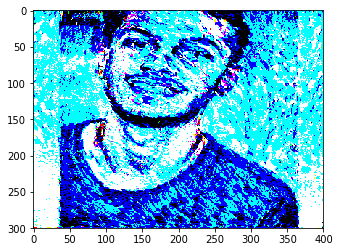

In [66]:
print(generated_image.shape)
imshow(generated_image[-1])